### Introduction
Our Group's name is FLO, which is based off of our last names, and our groups project is going to be based off of what section of Pittsburgh is the most environmentally friendly. To understand this, we decided that we should have each member of the group research a different section that either contributes to a place being greener or makes a place less environmentally friendly. The 3 sections our team researched was the density of trees in different counties of Pittsburgh, a census of where Illegal dumping of either hazardous or non decomposing materials took place, and finally, a study on particulate matter in Pittsburgh. From these datasets, we will come up with consistent ratings for each neighborhood, and combine a neighborhoods ratings in order to determine which neighborhood in Pittsburgh is the best.

### Metric

Our group decided to find the best neighborhood by trying to find the cleanest/most environmentally friendly neighborhood. We accomplished this by looking at these specific metrics:
+ Illegal Dumpsites: the amount of illegal dumpsites in each neighborhood
+ Trees: the amount of trees in each neighborhood
+ Particulate Matter: a measurement of air particulates/pollution in each neighborhood

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

### Illegal Dumpsites

,Neighborhood,estimated_tons
0,Allentown,10.4
1,Arlington,17.5
2,Banksville,1.0
3,Bedford Dwellings,1.0
4,Beechview,11.0
...,...,...
74,Upper Hill,7.4
75,West End,47.2
76,West Oakland,17.3
77,West Wood,1.0


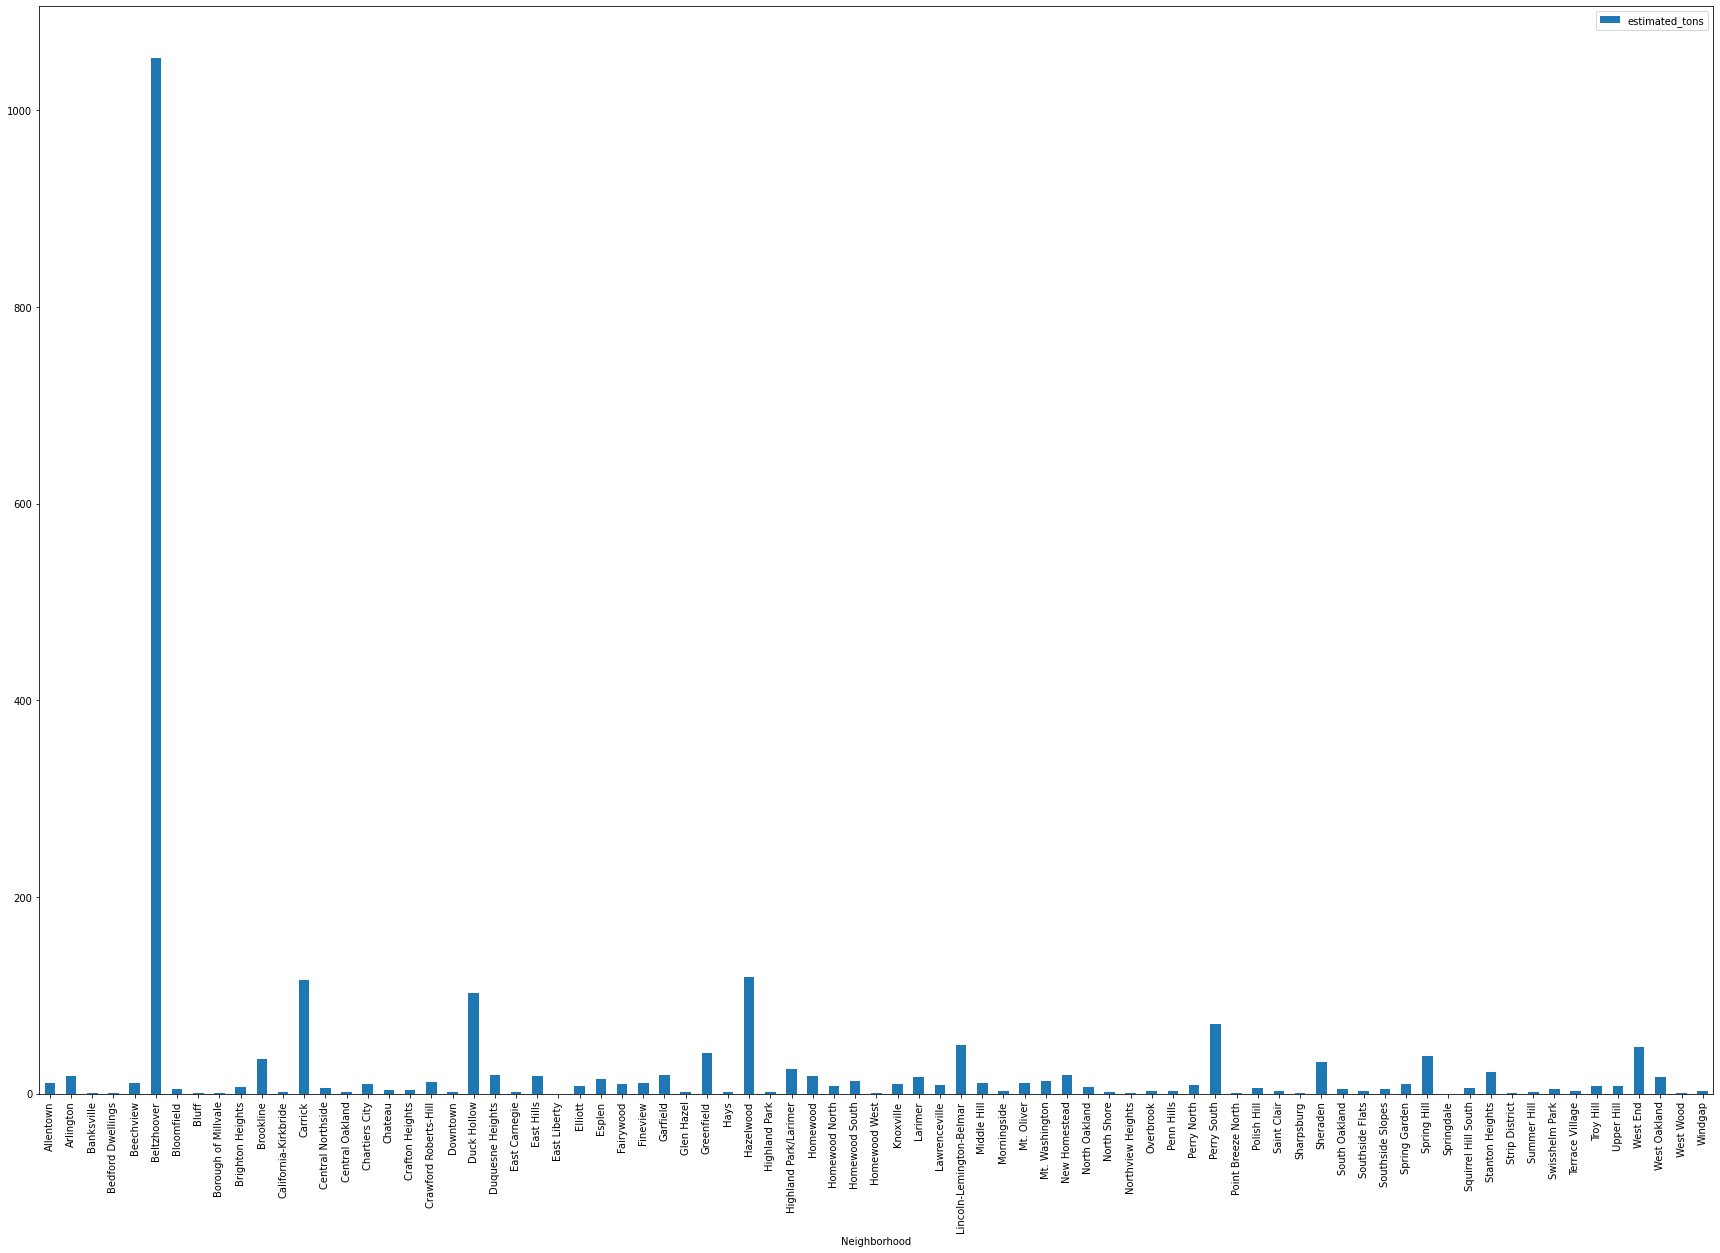

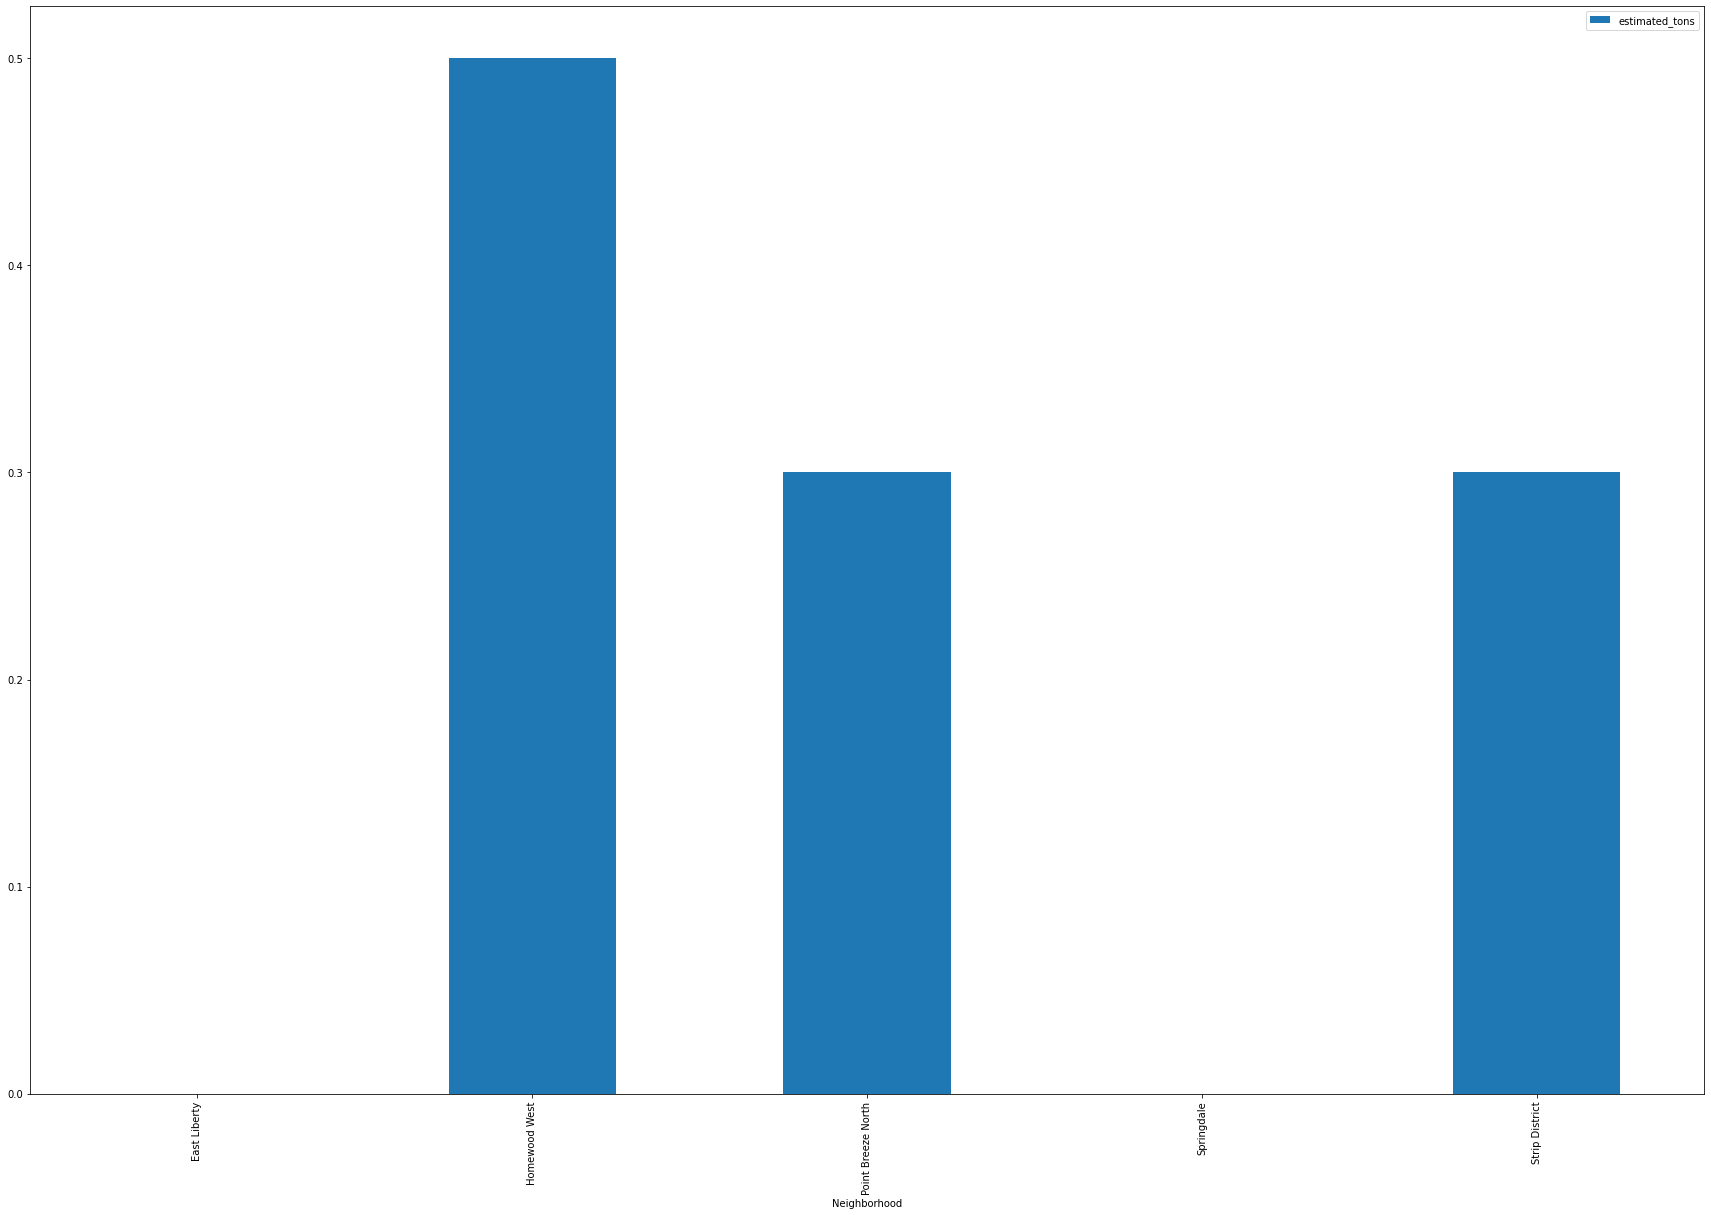

In [5]:
dump_site = pd.read_csv("https://data.wprdc.org/dataset/ed4cf849-d323-4d01-8a13-675d283f1ac9/resource/ee834d8d-ae71-4b3b-b02b-312ba321ff17/download/illegaldumpsites.csv")
dump = dump_site.loc[dump_site['City'] == 'Pittsburgh']
dumps = dump.drop(['site_name', 'Status','City','location_description','latitude','longitude'], axis = 1)
new_data = dumps.iloc[:,0:2]
new_data['estimated_tons']=new_data['estimated_tons'].astype(float)
new_illegal_dumpsites = new_data.groupby('Neighborhood', as_index = False).sum()
new_illegal_dumpsites.plot(x='Neighborhood', kind = 'bar', rot=90, figsize =(30,20))
best_illegal_dumpsites = new_illegal_dumpsites.loc[new_illegal_dumpsites['estimated_tons'] < .8]
best_illegal_dumpsites.plot(x='Neighborhood', kind = 'bar', rot=90, figsize =(30,20))
new_illegal_dumpsites.head(79)

### Trees

/opt/tljh/user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,amount
neighborhood,
Allegheny Center,867
Allegheny West,386
Allentown,84
Arlington,107
Arlington Heights,5
...,...
Upper Lawrenceville,373
West End,131
West Oakland,78


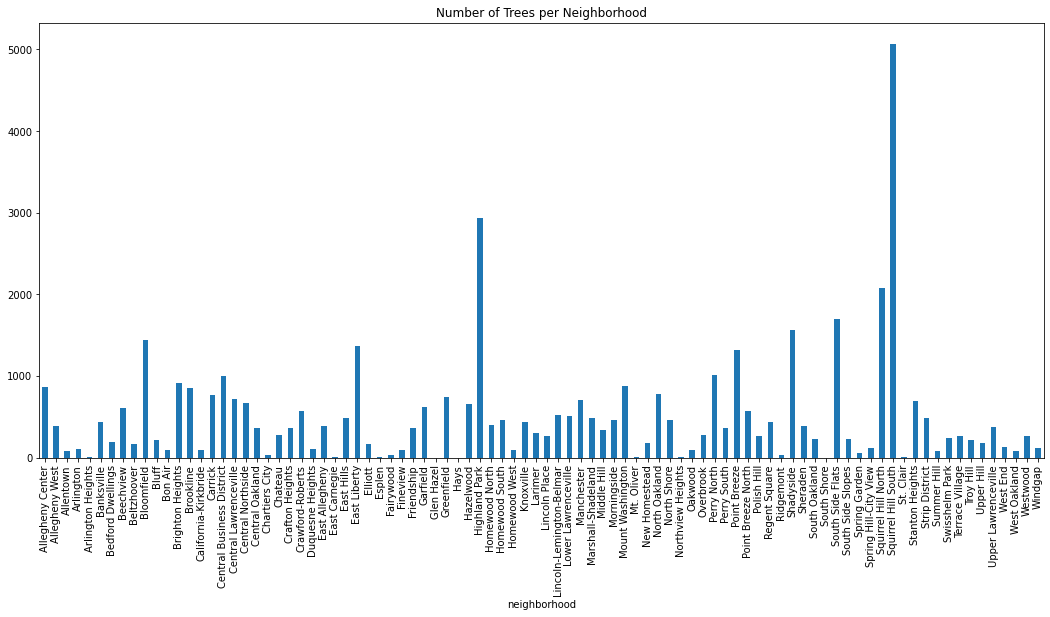

In [6]:
pitt_trees = pd.read_csv("datasets/Pittsburgh_Trees.csv")
pitt_trees['amount'] = 1
pitt_trees = pitt_trees[['neighborhood', 'amount']]
pitt_trees = pitt_trees.groupby(pitt_trees['neighborhood']).aggregate({'amount': 'sum'})
pitt_trees.plot(kind="bar", title="Number of Trees per Neighborhood", figsize=(18, 8), legend=False)
pitt_trees

,PM25
Neighborhood,
Chartiers City,12.157559
Upper Lawrenceville,12.157773
Summer Hill,12.160112
Morningside,12.162134
East Carnegie,12.169079
...,...
Glen Hazel,12.379904
Swisshelm Park,12.385153
Hays,12.386745


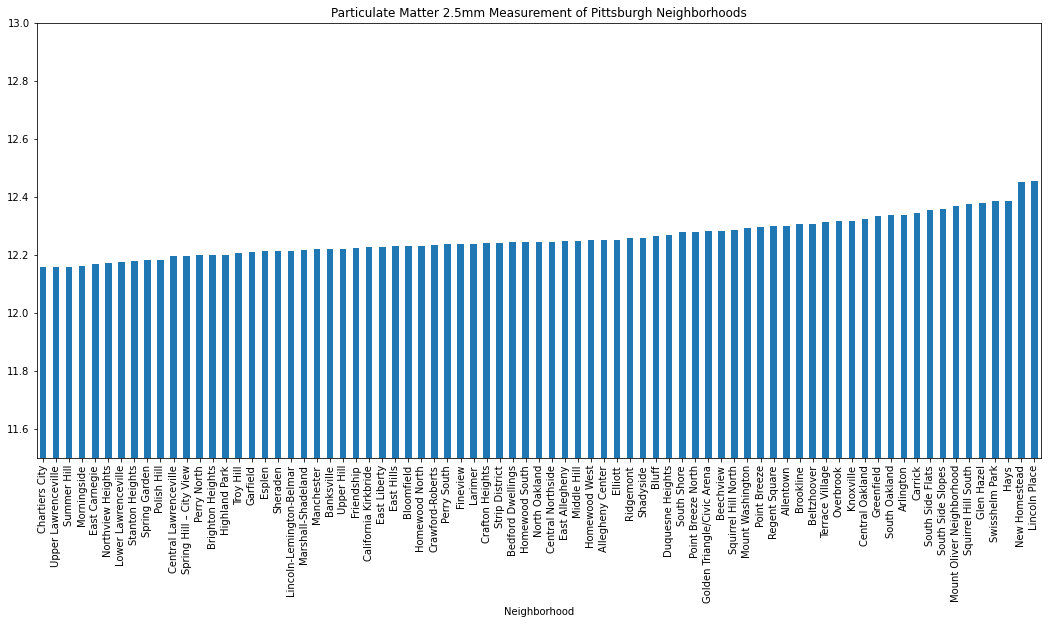

In [7]:
# Get data files as pandas dataframes
particulate_matter_pd = pd.read_csv("datasets/particulate_matter.csv")
pitt_census_tracts_pd = pd.read_csv("datasets/Pittsburgh_Census_Tracts.csv", encoding='cp1252') # there were encoding errors with utf-8, I just guessed the encoding of the file

# Only want census tracts from year 2010
census_tracts_mask = pitt_census_tracts_pd['Year'] == 2010
pitt_census_tracts_pd = pitt_census_tracts_pd[census_tracts_mask]

# Converts the census tracts to floats (there may also be more than one tract per entry)
def split_and_float(tract):
    tract_split = tract.split(', ')
    final_arr = []
    for tract in tract_split:
        final_arr.append(float(tract))
    return final_arr
pitt_census_tracts_pd['FloatTracts'] = pitt_census_tracts_pd['Census Tracts'].apply(split_and_float)

# For some reason the census tracts in this file are multiplied by 100
particulate_matter_pd['RealTract'] = particulate_matter_pd['CensusTract'] / 100

# Identifies the Neighborhood of each census tract and attaches it to particulate matter dataframe (this is really slow but necessary since there are neighborhoods with multiple census tracts)
def find_neighborhood(tract):
    for index, row in pitt_census_tracts_pd.iterrows():
        if tract in row['FloatTracts']:
            return row['Neighborhood']
    return 'N/A'
particulate_matter_pd['Neighborhood'] = particulate_matter_pd['RealTract'].apply(find_neighborhood)
part_mask = particulate_matter_pd['Neighborhood'] != 'N/A'
particulate_matter_pd = particulate_matter_pd[part_mask]

# We don't need the census tracts anymore now that the neighborhoods are matched up
particulate_matter_pd.drop(["CensusTract", "RealTract"], axis=1, inplace=True)

# Merges rows with same neighborhood, pm rating is the max of all pm ratings of the neighborhood
particulate_matter_pd = particulate_matter_pd.groupby(particulate_matter_pd['Neighborhood']).aggregate({'PM25': 'max'})

# Order neighborhoods by PM25 rating, going from lowest to highest
particulate_matter_pd.sort_values(by=["PM25"], inplace=True)

# Plot a bar graph of the data
particulate_matter_pd.plot(kind="bar", title="Particulate Matter 2.5mm Measurement of Pittsburgh Neighborhoods", figsize=(18, 8), ylim=(11.5, 13), legend=False)

particulate_matter_pd

### Conclusion

In [15]:
pitt_trees_ordered = pitt_trees.sort_values(by=["amount"], ascending=False)
illegal_dumpsites_ordered = new_illegal_dumpsites.sort_values(by=['estimated_tons']).set_index('Neighborhood')

rankings_dict = {}
curr_ranking = 1
for index, row in pitt_trees_ordered.iterrows():
    rankings_dict[index] = [curr_ranking]
    curr_ranking += 1
    
curr_ranking = 1
for index, row in illegal_dumpsites_ordered.iterrows():
    if index in rankings_dict.keys():
        rankings_dict[index].append(curr_ranking)
    else:
        rankings_dict[index] = [curr_ranking]
    curr_ranking += 1

curr_ranking = 1
for index, row in particulate_matter_pd.iterrows():
    if index in rankings_dict.keys():
        rankings_dict[index].append(curr_ranking)
    else:
        rankings_dict[index] = [curr_ranking]
    curr_ranking += 1

print(rankings_dict['Highland Park'][2])
print(rankings_dict['East Liberty'][2])

rankings_dict_total = {}
for key in rankings_dict.keys():
    if (len(rankings_dict[key]) == 3):
        rankings_dict_total[key] = [sum(rankings_dict[key])]
    
rankings_pd = pd.DataFrame().from_dict(rankings_dict_total, orient='index').rename(columns={0: "Ranking"}).sort_values(by=["Ranking"])

rankings_pd

15
27


,Ranking
Highland Park,36
East Liberty,36
Morningside,61
Brighton Heights,64
Banksville,64
Perry North,66
Bloomfield,68
Strip District,69
Point Breeze North,81
North Oakland,92


#### We have a tie for best neighborhood between Highland Park and East Liberty
We concluded this by ranking each neighborhood for each metric (based of its position), adding those rankings up, and seeing who had the smallest sum. We excluded neighborhoods who didn't appear in all of the metrics

#### Erasto Omolo
Using our datasets and analytics, we found that East Liberty, and Highland Park had the best rankings when it came down to each of our metrics combined. Our data driven determination found Pittsburgh's "best neighborhood" in terms of environmentally-cleanness, because that is what me and my peers thought made one neighborhood better than the other.  Personally, I believe that North Squirrel Hill is the best in these terms, because it is near Schenely Park, and has many trees, and an earthly vibe to it. Although, Oakland is my favorite neighborhood in Pittsburgh for now because I consider it home and it has the beautiful Cathedral. It is not very environmentally friendly though.

#### Jackson Frank
Through our analysis of our data, we concluded that both East Liberty and Highland Park are tied for the best neighborhood in Pittsburgh. I personally feel that environmentally friendliness is a better measure of what neighborhood is the best, as more traditional measurements like crime rate and incomes can be more heavily influenced by complex and even discriminatory factors. Personally, I haven't been able to explore the neighborhoods of Pittsburgh as much as I would've liked, however my personal favorite for now is probably Oakland since I now call this place home.